In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

In [3]:
def cles_ind(x1, x2):
    """Calc common language effect size
    
    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.
    
    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361
    
    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

See more about data source/description [here](https://rdrr.io/rforge/Ecdat/man/OFP.html)

In [4]:
rename_map = {
    "ofp": "n_phys_visits",
    "ofnp": "n_non_phys_visits",
    "opp": "n_phys_outpatient",
    "opnp": "n_non_phys_outpatient",
    "emr": "n_er_visits",
    "hosp": "n_hosp_visits",
    "numchron": "n_chronic_cond",
    "adldiff": "has_limiting_cond",
    "faminc": "family_income",
    "privins": "prvt_ins",
    "hlth": "health",
}

<IPython.core.display.Javascript object>

In [5]:
data_path = "data/physician-visits.csv"

<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv(data_path, index_col=0)
df = df.rename(columns=rename_map)

# Family income is in units of 10,000
# make this conversion
df["family_income"] *= 10000

# Note, adam is scared of this
df = df.replace({"yes": 1, "no": 0})

# Double check column types
# print(df.dtypes)

df.head()

,n_phys_visits,n_non_phys_visits,n_phys_outpatient,n_non_phys_outpatient,n_er_visits,n_hosp_visits,n_chronic_cond,has_limiting_cond,age,black,sex,maried,school,family_income,employed,prvt_ins,medicaid,region,health
1,5,0,0,0,0,1,2,0,6.9,1,male,1,6,28810.0,1,1,0,other,other
2,1,0,2,0,2,0,2,0,7.4,0,female,1,10,27478.0,0,1,0,other,other
3,13,0,0,0,3,3,4,1,6.6,1,female,0,10,6532.0,0,0,1,other,poor
4,16,0,5,0,1,1,2,1,7.6,0,male,1,3,6588.0,0,1,0,other,poor
5,3,0,0,0,0,0,2,1,7.9,0,female,1,6,6588.0,0,1,0,other,other


<IPython.core.display.Javascript object>

In [7]:
# Total number of NAs in whole df
df.isna().sum().sum()

0

<IPython.core.display.Javascript object>

#### Question: Does level of `'health'` relate to `'family_income'`?

In [8]:
df[["health", "family_income"]].dtypes

health            object
family_income    float64
dtype: object

<IPython.core.display.Javascript object>

In [9]:
df["health"].value_counts()

other        3509
poor          554
excellent     343
Name: health, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
df.groupby("health").agg({"family_income": ["mean", "median"]})

family_income         
                   mean   median
health                          
excellent  32774.114577  22719.0
other      25519.896449  17469.0
poor       19051.624621  11988.0

<IPython.core.display.Javascript object>

In [11]:
# TODO: follow up on what the 'other' category is?
# Can it include potentially excellent/poor health participants?
# Is it exclusively meaning 'not excellent or poor'?

<IPython.core.display.Javascript object>

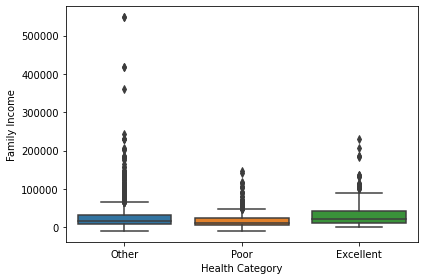

<IPython.core.display.Javascript object>

In [12]:
# TODO: should we keep what looks to be 3 income outliers
# in the other category?  Is it really only 3 above 300K?
# Other is a big group, we're not data poor, consider how dropping
# would affect the analysis.

plot_df = df.copy()
plot_df["health"] = plot_df["health"].str.title()

sns.boxplot("health", "family_income", data=plot_df)
plt.ylabel("Family Income")
plt.xlabel("Health Category")
plt.tight_layout()
plt.savefig("imgs/boxplot.png")
plt.show()

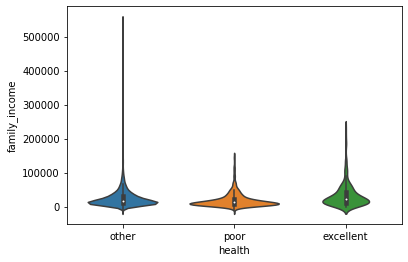

<IPython.core.display.Javascript object>

In [13]:
sns.violinplot("health", "family_income", data=df)
plt.show()

We have 3 groups, so we might ANOVA.  We need to check assumptions.

* Continuous? Yep
* Independent? Yep
* Normal? Not

In [14]:
# (df["family_income"] == 0).sum()
# Result: 18 records with 0 income

# TODO: come back and re-evaluate if dropping 0s is a good idea
# for now, dropping to investigate if log transform is a good idea

# TODO: for now, going to proceed with a non-parametric test
# potentially, re-investigate normality assumption w/ log transform
# and use ANOVA
df = df[df["family_income"] > 0]

<IPython.core.display.Javascript object>

In [15]:
other = df[df["health"] == "other"]
poor = df[df["health"] == "poor"]
excellent = df[df["health"] == "excellent"]

<IPython.core.display.Javascript object>

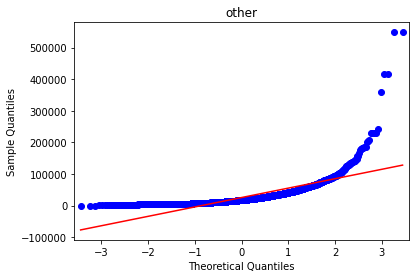

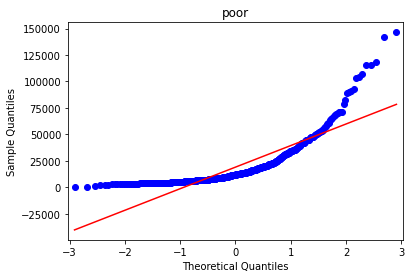

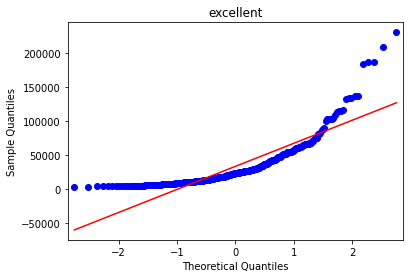

<IPython.core.display.Javascript object>

In [16]:
sm.qqplot(other["family_income"], line="s")
plt.title("other")
plt.show()

sm.qqplot(poor["family_income"], line="s")
plt.title("poor")
plt.show()

sm.qqplot(excellent["family_income"], line="s")
plt.title("excellent")
plt.show()

In [17]:
_, p = stats.kruskal(
    other["family_income"], poor["family_income"], excellent["family_income"]
)

reject = p < 0.05
reject

True

<IPython.core.display.Javascript object>

In [18]:
_, p1 = stats.kruskal(other["family_income"], poor["family_income"])

_, p2 = stats.kruskal(other["family_income"], excellent["family_income"])

_, p3 = stats.kruskal(poor["family_income"], excellent["family_income"])

reject, corrected_p, _, _ = multipletests([p1, p2, p3])
reject

array([ True,  True,  True])

<IPython.core.display.Javascript object>

#### Common language effect size

> Interpret as the probability that a score sampled at random from one distribution will be greater than a score sampled from some other distribution.

In [19]:
cles = cles_ind(other["family_income"], poor["family_income"])

print(f'other health median income: {other["family_income"].median()}')
print(f'poor health median income: {poor["family_income"].median()}')
print("------------------------------------")
print(f"Effect size {cles}")

other health median income: 17586.0
poor health median income: 12054.0
------------------------------------
Effect size 0.6093629996803375


<IPython.core.display.Javascript object>

In [20]:
cles = cles_ind(other["family_income"], excellent["family_income"])

print(f'other health median income: {other["family_income"].median()}')
print(f'excellent health median income: {excellent["family_income"].median()}')
print("------------------------------------")
print(f"Effect size {cles}")

other health median income: 17586.0
excellent health median income: 22754.0
------------------------------------
Effect size 0.5628583776829642


<IPython.core.display.Javascript object>

In [21]:
cles = cles_ind(poor["family_income"], excellent["family_income"])

print(f'poor health median income: {poor["family_income"].median()}')
print(f'excellent health median income: {excellent["family_income"].median()}')
print("------------------------------------")
print(f"Effect size {cles}")

poor health median income: 12054.0
excellent health median income: 22754.0
------------------------------------
Effect size 0.6588376133570641


<IPython.core.display.Javascript object>